In [1]:
# data analysis and wrangling
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# from wand.image import Image as WImage
# img = WImage(filename='/kaggle/input/welocalize/Welocalize - Assessment Instructions.pdf')
# img

# Assessment Criteria:
Testing your: 
- [ ] creativity
- [ ] analytics fundamentals
- [ ] technical knowledge
- [ ] communication
- [ ] connecting data to people/processes/business outcomes

1. How I create insights
2. How I communicate insights
3. Questions I ask Kevin/stakeholders before heading into analysis

# Problem:

* Interested in understanding how frequently we deliver to our customers on time, vs. how frequently we are late.
* What factors contribute to our on-time delivery (OTD) rates. --correlations
* And how we can do better at delivering on time? --theoretically and what data provides as delivery failure activity
* Also interested to know what other insights you can derive from this data (not necessarily related to OTD rates). --looking at translation service's main KPI's and what what provided data can answer other than delivery time; look at competitors' case studies

## Context around Problem:
    
* Why is this problem being investigated:

At times, Welocalize has put a lot of focus/effort onto <font color='red'>client retention and satisfaction</font>. And we've heard from clients that <font color='red'>worse-than-expected on-time delivery rates</font> is one of the biggest things that makes them dissatisfied.

* Company threshold for what is an alarming rate of tardy deliverables:

It varies by customer and by program, but the great majority of customers expect <font color='red'>90-95%</font> of deliverables to be delivered on time.

* What would be considered an improvement?

Meeting customers' expectations.

* What time interval are we measuring punctual/late deliveries (per month/per week)?

Again, it can vary; some high-volume customers/programs might look at it daily. But probably the most typical way to look at it is <font color='red'>by month</font>.


* Reason for heavy sparseness of data in column -average_duration_request_received_to_quoted_business_seconds:

Some projects are not quoted, because we have a <font color='red'>long-term contract with the client that allows us to skip the quoting process</font>, and start work on all their requests/projects immediately, without any quote (and quote approval) process. If there is no quote for a given project, then there is no duration here.

In [3]:
data = pd.read_excel(r'/kaggle/input/welocalize/welocalize_dataset.xlsx', sheet_name= 'data')
data

,client_deliverable_id,date_client_deliverable_delivered,total_tasks,words,average_duration_request_received_to_quoted_business_seconds,average_duration_offer_sent_to_task_claimed_seconds,average_duration_task_claimed_to_task_started_seconds,translations_for_client_by_supplier_to_date,source_language_locale_code,target_language_locale_code,project_manager_id,requests_managed_simultaneously_by_project_manager,content_specialty,translation_supplier_id,service_line,lateness_of_client_deliverable_seconds,is_client_deliverable_past_due
0,1639999,2022-02-02,11,21354,5572.340,103048.0,124904.0,1,en-US,ja-JP,3424244246268217782,816,Chemistry,Pantheon_11922,Legal & Financial Services,NaN,N
1,1658115,2022-02-01,8,1344,5771.707,157246.0,188189.0,33,en-US,sq-AL,3908128739217598266,324,Chemistry,Pantheon_5920,Legal & Financial Services,NaN,N
2,1658124,2022-02-01,12,20714,5771.707,352535.0,205806.0,13,en-US,el-GR,3908128739217598266,324,Chemistry,Pantheon_5881,Legal & Financial Services,NaN,N
3,1658129,2022-02-01,7,1344,5771.707,204319.0,193394.0,16,en-US,lt-LT,3908128739217598266,324,Chemistry,Pantheon_5922,Legal & Financial Services,NaN,N
4,1658134,2022-02-01,10,20714,5771.707,354784.0,339963.0,8,en-US,pt-PT,3908128739217598266,324,Chemistry,Pantheon_6813,Legal & Financial Services,NaN,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99694,5406402,2022-12-30,2,9,NaN,191.0,2026.0,112,en-US,ru-RU,6712390449850189908,17,Marketing,Pantheon_913,Localization,NaN,N
99695,5406925,2022-12-30,1,2,NaN,633.0,2.0,287,en-US,cs-CZ,1201051988300040006,34,Marketing,Pantheon_29997,Localization,NaN,N
99696,5407305,2022-12-30,2,50,NaN,NaN,713.0,831,en-US,ro-RO,2341318023614218099,181,Marketing,Pantheon_835,Localization,NaN,N
99697,5407454,2022-12-30,2,16,NaN,663.0,147.0,349,en-US,it-IT,2341318023614218099,179,Marketing,Pantheon_160,Localization,NaN,N


In [4]:
data.shape

(99699, 17)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99699 entries, 0 to 99698
Data columns (total 17 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   client_deliverable_id                                         99699 non-null  int64  
 1   date_client_deliverable_delivered                             99699 non-null  object 
 2   total_tasks                                                   99699 non-null  int64  
 3   words                                                         99699 non-null  int64  
 4   average_duration_request_received_to_quoted_business_seconds  1579 non-null   float64
 5   average_duration_offer_sent_to_task_claimed_seconds           92870 non-null  float64
 6   average_duration_task_claimed_to_task_started_seconds         98391 non-null  float64
 7   translations_for_client_by_supplier_to_date                   99699

In [6]:
data.isnull().sum()

client_deliverable_id                                               0
date_client_deliverable_delivered                                   0
total_tasks                                                         0
words                                                               0
average_duration_request_received_to_quoted_business_seconds    98120
average_duration_offer_sent_to_task_claimed_seconds              6829
average_duration_task_claimed_to_task_started_seconds            1308
translations_for_client_by_supplier_to_date                         0
source_language_locale_code                                         0
target_language_locale_code                                         0
project_manager_id                                                  0
requests_managed_simultaneously_by_project_manager                  0
content_specialty                                                   0
translation_supplier_id                                             0
service_line        

# SQL Pre-processing. Code here:
1. Below are views created after separating out deliverable info from requests translation task info. Requests comprise of multiple deliverables. And deliverables have multiple tasks which can include a translation task. So the dataset is of mixed granularity.
2. Taking out NULL values from is_client_deliverable_past_due (2 rows only; low % of whole dataset)
3. Transforming data into correct data given column logic (boolean -> TRUE/FALSE)
4. Creating consistent precision (round to nearest seconds vs having seconds to thousandth's place)


In [7]:
requests = pd.read_csv('/kaggle/input/welocalize/requests.csv')
deliverables = pd.read_csv('/kaggle/input/welocalize/deliverables.csv')
translation_task = pd.read_csv('/kaggle/input/welocalize/translation_task.csv')

# CLASSIFYING

# CORRELATING

# CHARTING

# Starting with deliverables:

* Categorical:    
date_client_deliverable_delivered, is_client_deliverable_past_due  

* Numerical:
total_tasks, words, average_duration_offer_sent_to_task_claimed_seconds, average_duration_task_claimed_to_task_started_seconds, lateness_of_client_deliverable_seconds 

* Columns with errors:
There are no mixed data types. And features were corrected for Boolean column to have Boolean types and seconds measurements consistently rounded to tenths place.

Columns with blanks, null or empty values: The original dataset showed huge amount of sparseness in column: average_duration_request_received_to_quoted_business_seconds. So not much can be derived from this other than business is doing well if requests do not need quote before starting work on requests.

In [8]:
deliverables.shape

(99697, 11)

In [9]:
deliverables.head()

,client_deliverable_id,date_client_deliverable_delivered,total_tasks,words,average_duration_offer_sent_to_task_claimed_seconds,average_duration_offer_sent_to_task_claimed_hours,average_duration_task_claimed_to_task_started_seconds,average_duration_task_claimed_to_task_started_days,lateness_of_client_deliverable_seconds,lateness_of_client_deliverable_days,is_client_deliverable_past_due
0,1639999,2022-02-02,11,21354,103048.0,28.624444,124904.0,1.445648,NaN,NaN,False
1,1658115,2022-02-01,8,1344,157246.0,43.679444,188189.0,2.178113,NaN,NaN,False
2,1658124,2022-02-01,12,20714,352535.0,97.926389,205806.0,2.382014,NaN,NaN,False
3,1658129,2022-02-01,7,1344,204319.0,56.755278,193394.0,2.238356,NaN,NaN,False
4,1658134,2022-02-01,10,20714,354784.0,98.551111,339963.0,3.934757,NaN,NaN,False


In [10]:
deliverables.isnull().sum()

client_deliverable_id                                        0
date_client_deliverable_delivered                            0
total_tasks                                                  0
words                                                        0
average_duration_offer_sent_to_task_claimed_seconds       6828
average_duration_offer_sent_to_task_claimed_hours         6828
average_duration_task_claimed_to_task_started_seconds     1307
average_duration_task_claimed_to_task_started_days        1307
lateness_of_client_deliverable_seconds                   90260
lateness_of_client_deliverable_days                      90260
is_client_deliverable_past_due                               0
dtype: int64

In [11]:
# Distribution of numerical features:`

deliverables[['total_tasks',
 'words',
 'average_duration_offer_sent_to_task_claimed_hours',
 'average_duration_task_claimed_to_task_started_days',
 'lateness_of_client_deliverable_days']].describe()

,total_tasks,words,average_duration_offer_sent_to_task_claimed_hours,average_duration_task_claimed_to_task_started_days,lateness_of_client_deliverable_days
count,99697.000000,99697.000000,92869.000000,98390.000000,9437.000000
mean,2.940700,1366.244441,15.161682,1.402456,10.326718
std,2.003716,6286.567791,36.195716,2.442345,16.522251
min,1.000000,0.000000,0.000278,0.000000,0.000014
25%,2.000000,24.000000,0.726944,0.116438,1.110137
50%,2.000000,120.000000,4.015278,0.611447,4.815762
75%,3.000000,578.000000,13.348611,1.680883,11.629934
max,61.000000,257709.000000,974.623611,75.913426,289.416480


* Total samples: 99699
* Average 3 tasks/deliverable with minimum 1 task and at most 61 tasks
* Average amount of words translated in deliverable: 1366
* Average time it takes for Welocalize to accept task: 54581 seconds/15 hours with max time: 40 days
* Average time it takes for Welocalize to start accepted task: 1.4 days
* Average late time on delivery: 10.3 days

In [12]:
# Distribution of categorical features:

deliverables.describe(include=['O'])

,date_client_deliverable_delivered
count,99697
unique,364
top,2022-10-19
freq,571


* date delivered:
** sample is almost whole year: 2022
** looks like there was a huge deadline/submissions on 10/19
* flag for client deliverable being past due date:
** two missing values
** majority of deliverables are not late

# Visualizations

In [13]:
# Time Interval We are Looking At

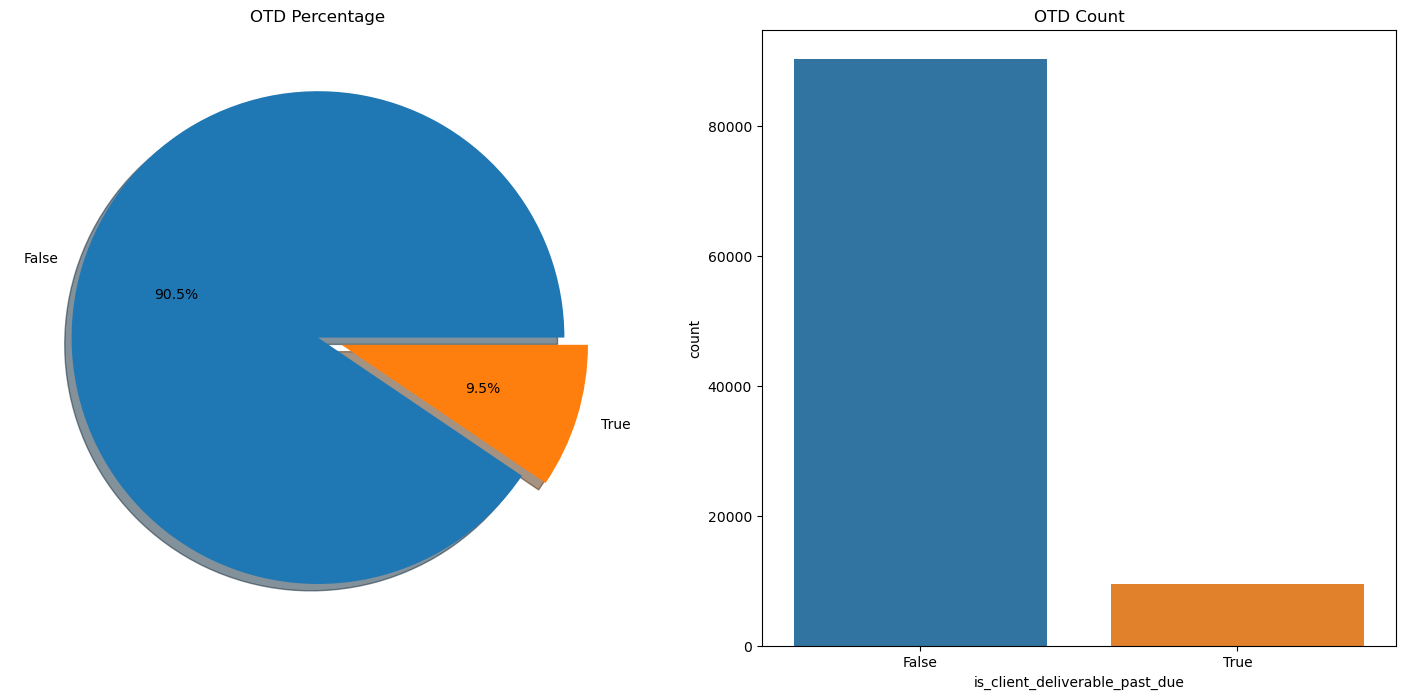

In [14]:
# How Many Delivered On Time?

f,ax=plt.subplots(1,2,figsize=(18,8))
deliverables['is_client_deliverable_past_due'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('OTD Percentage')
ax[0].set_ylabel('')
sns.countplot(x = 'is_client_deliverable_past_due',data=deliverables,ax=ax[1]) 
ax[1].set_title('OTD Count')
plt.show()

Percentage of non-OTD is around 10%. And after some discussion with stakeholder, customer expects 90-95% deliverables to be on time even though Welocalize aims for 100%. So year 2022 OTD metric was within range, but there is still room for improvement. 

# Analyzing Columns That Could Contribute to Delivery Time

# Reminder

Categorical:
date_client_deliverable_delivered, is_client_deliverable_past_due

Numerical: total_tasks, words, average_duration_offer_sent_to_task_claimed_seconds, average_duration_task_claimed_to_task_started_seconds, lateness_of_client_deliverable_seconds

Columns with errors: There are no mixed data types. And features were corrected for Boolean column to have Boolean types and seconds measurements consistently rounded to tenths place.

In [15]:
# Dataset Timeframe
deliverables.date_client_deliverable_delivered.min(), deliverables.date_client_deliverable_delivered.max()


('2022-01-01', '2022-12-30')

Total timeframe of data is 354 days from year: 2022.

In [16]:
# Let's get different trends of OTD and non-OTD broken down by month and week.
monthly = pd.read_csv('/kaggle/input/welocalize/month_freqs.csv')
weekly = pd.read_csv('/kaggle/input/welocalize/week_freqs.csv')

OTD percent is total # of on time deliverables over total deliverables and for non-OTD vice versa.

### Monthly:

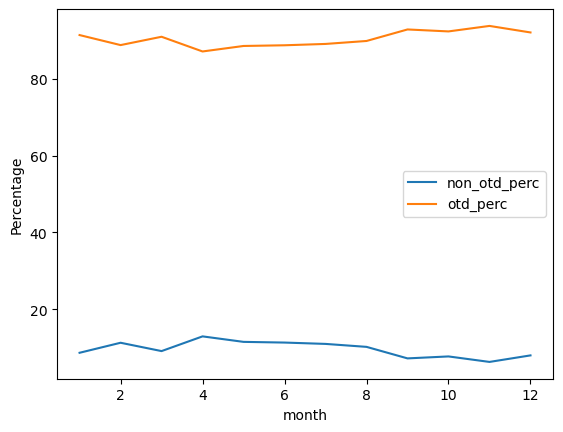

In [17]:
monthly.plot(x="month", y=["non_otd_perc", "otd_perc"])
plt.ylabel('Percentage')
plt.show()

This just shows us how big of a difference there is between OTD's and non-OTD's. 

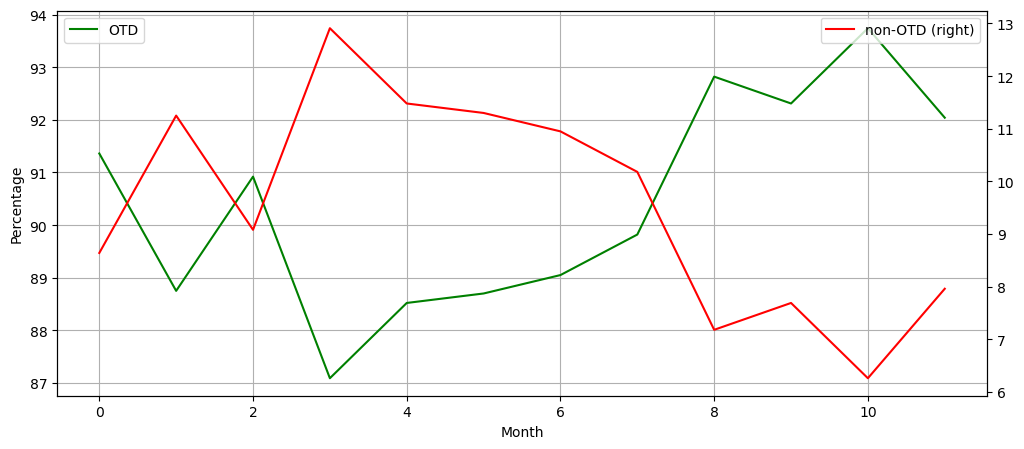

In [18]:
plt.figure(figsize=(12,5))
plt.xlabel('Month')
plt.ylabel('Percentage')

ax1 = monthly.otd_perc.plot(color='green', grid=True, label='OTD')
ax2 = monthly.non_otd_perc.plot(color='red', grid=True, secondary_y=True, label='non-OTD')

ax1.legend(loc=2)
ax2.legend(loc=1)

plt.show()

This graph is more illuminating because it let's us see better inflections within each percentage and between OTD's and non-OTD's, when trend is down, what is the relationship with the other graph. 

## Observation:
As we can see here is that OTD's hit a low in March and have peaked after that with a slight dip at end of the year. Would be interesting to see what contributed to non-OTD's in March and peak of OTD's in October.

### Weekly

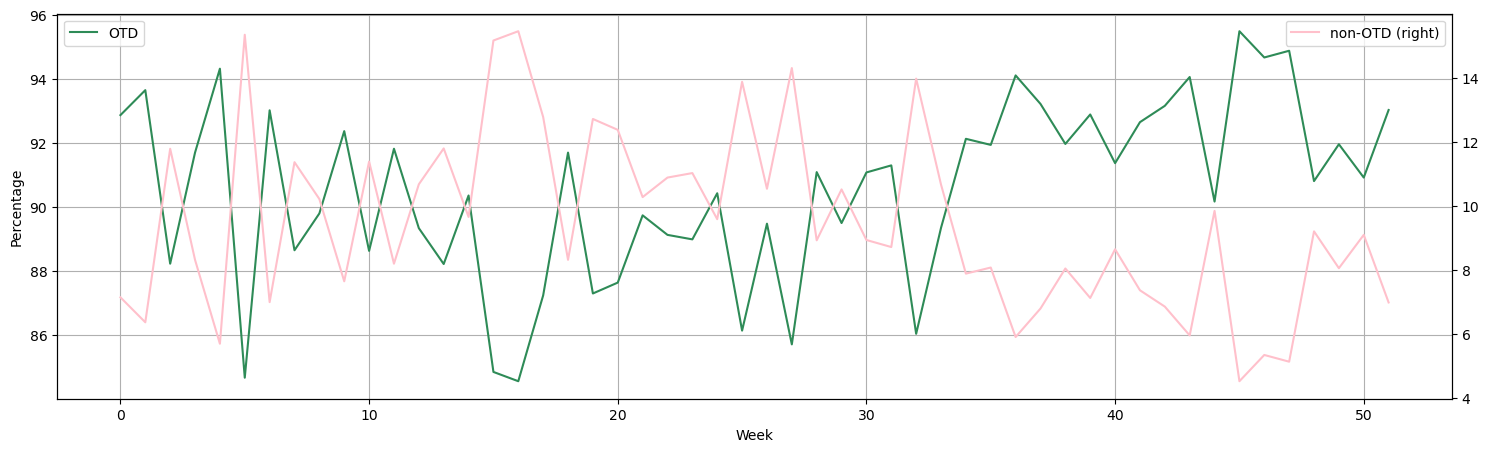

In [19]:
plt.figure(figsize=(18,5))
plt.xlabel('Week')
plt.ylabel('Percentage')

ax1 = weekly.otd_perc.plot(color='seagreen', grid=True, label='OTD')
ax2 = weekly.non_otd_perc.plot(color='pink', grid=True, secondary_y=True, label='non-OTD')

ax1.legend(loc=2)
ax2.legend(loc=1)

plt.show()

## Observation:

It gets more interesting at the weekly level. At this level of granularity, we see OTD's drop significantly every 10 weeks until appoximately 32nd week of 2022/August.

In [20]:
# Day of Month

In [21]:
# Day in Week